In [2]:
import pandas as pd
import glob
from matplotlib import pyplot as plt
import matplotlib
import dask 
import dask.dataframe as dd
from  scipy.interpolate import interp1d
import numpy as np
import gc
from typing import Dict, Tuple
import sys
import analysis_toolbox as at
import papermill
import logging
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Parameters

fill_nb = "8033"


In [4]:
# Logging

log_path = "/eos/project/l/lhc-lumimod/LuminosityFollowUp/BBCW_ANALYSIS/LOG"
log_file = log_path + f"/FILL_{int(fill_nb)}.log"

logging.basicConfig(format='%(asctime)s | %(levelname)s:%(message)s', filename=log_file, encoding='utf-8', level=logging.INFO)


In [5]:
logging.info("Starting analysis.")

# Fill number, data and variables

path_to_data = at.path_to_data
variables_of_interest = at.variables_of_interest
fill_of_interest = int(fill_nb)
bmode_of_interest = 'STABLE'

# Load data

logging.info("Loading Data...")

try:
    data_df = dd.read_parquet(path_to_data+f'HX:FILLN={fill_of_interest}'+f"/HX:BMODE={bmode_of_interest}",
                         columns=variables_of_interest).compute().sort_index()

    # Filter with only beta star of 30 cm
    data_df = data_df[data_df['HX:BETASTAR_IP1']==30]

    # Nb collisions in each IP

    injection_scheme = data_df['LHC.STATS:LHC:INJECTION_SCHEME'].iloc[0]
    nb_coll_ip1_5 = int(injection_scheme.split('_')[2])
    nb_coll_ip2 = int(injection_scheme.split('_')[3])
    nb_coll_ip8 = int(injection_scheme.split('_')[4])
    logging.info("Success.")
except:
    logging.error("Data couldn't be retrieved. Skipping fill.")
    

In [6]:
# Split the data

data_to_interp = data_df[at.interp_var].copy()
data_no_interp = data_df[at.no_interp_var].copy()

del data_df

In [7]:
# Let's interpolate the data, and reindex with datetime


interp_period_s = 30 # in seconds 

df_interpolated = at.interpolate_df(data_to_interp, period_s=interp_period_s)

data_inter_fin = at.pandas_index_localize(df_interpolated)
data_no_inter_fin = at.pandas_index_localize(data_no_interp)


del data_to_interp, data_no_interp

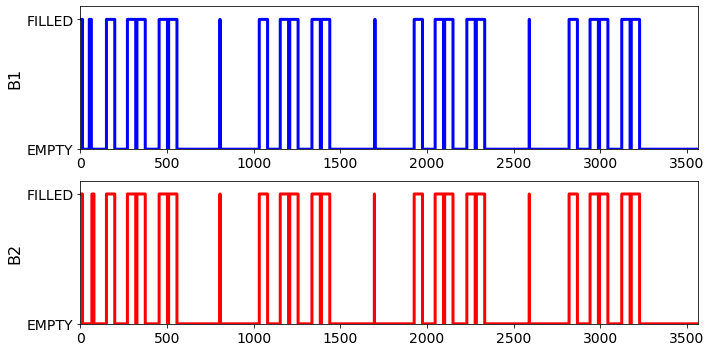

In [8]:
# Let's plot the filling scheme

fill_scheme_dict = at.get_filling_pattern(data_inter_fin)

fig = at.plot_filling_scheme(fill_dict=fill_scheme_dict)

In [9]:
# Let's compute the effective cross section (bbb)

data_filtered = data_inter_fin[data_inter_fin['event flag']==False].copy()
del data_inter_fin

xsection_dict = at.compute_effective_xsection(data_df=data_filtered, fill_scheme_dict=fill_scheme_dict,
                                              resampling_time_s=interp_period_s, nb_coll_ip8=nb_coll_ip8)


 

/home/apoyet/LHC_LUMI/fills-toolbox/./wires_fills_analysis/analysis_toolbox.py:231: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bbb_df[f"b_{bunch}"] = input_series.dropna().apply(lambda x:x[bunch])
/home/apoyet/LHC_LUMI/fills-toolbox/./wires_fills_analysis/analysis_toolbox.py:231: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  bbb_df[f"b_{bunch}"] = input_series.dropna().apply(lambda x:x[bunch])
/home/apoyet/LHC_LUMI/fills-toolbox/./wires_fills_analysis/analysis_toolbox.py:231: PerformanceWarning: DataFrame is highly fragmented

In [37]:
# Time windows around wires powering

wire_on_timestamp = data_no_inter_fin[data_no_inter_fin['RPMC.UL14.RBBCW.L1B1:I_MEAS']>300]['RPMC.UL14.RBBCW.L1B1:I_MEAS'].index[0]

t0 = f'{(wire_on_timestamp - pd.Timedelta(30, "minutes")).hour}:{(wire_on_timestamp - pd.Timedelta(30, "minutes")).minute}'
t1 = f'{(wire_on_timestamp - pd.Timedelta(15, "minutes")).hour}:{(wire_on_timestamp - pd.Timedelta(15, "minutes")).minute}'
t2 = f'{(wire_on_timestamp + pd.Timedelta(15, "minutes")).hour}:{(wire_on_timestamp + pd.Timedelta(15, "minutes")).minute}'
t3 = f'{(wire_on_timestamp + pd.Timedelta(30, "minutes")).hour}:{(wire_on_timestamp + pd.Timedelta(30, "minutes")).minute}'

In [38]:
# Average data 

wires_off_b1 = xsection_dict['b1'].between_time(t0, t1).mean()
wires_off_b2 = xsection_dict['b2'].between_time(t0, t1).mean()

wires_on_b1 = xsection_dict['b1'].between_time(t2, t3).mean()
wires_on_b2 = xsection_dict['b2'].between_time(t2, t3).mean()

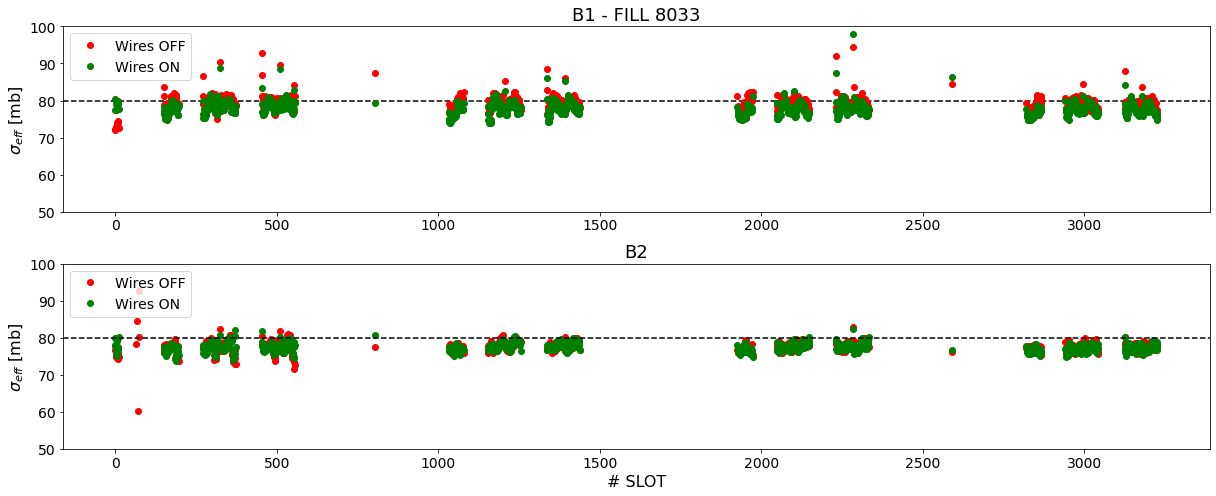

In [44]:
# And plot

plt.figure(figsize=(17,7))

y_lim = (50,200)

ax_b1 = plt.subplot(211)
ax_b1.axhline(y=80, c='k', ls='--')
ax_b1.plot(fill_scheme_dict['B1'], (wires_off_b1/1000).to_numpy(), 'ro', label='Wires OFF')
ax_b1.plot(fill_scheme_dict['B1'], (wires_on_b1/1000).to_numpy(), 'go', label='Wires ON')
plt.legend(loc='upper left', fontsize=14)
plt.ylim(y_lim)
ax_b1.set_ylabel("$\\sigma_{eff}$ [mb]", fontsize=16)
plt.tick_params(labelsize=14)
ax_b1.set_title(f"B1 - FILL {fill_of_interest}", fontsize=18)


ax_b2 = plt.subplot(212)
ax_b2.plot(fill_scheme_dict['B2'], (wires_off_b2/1000).to_numpy(), 'ro', label='Wires OFF')
ax_b2.plot(fill_scheme_dict['B2'], (wires_on_b2/1000).to_numpy(), 'go', label='Wires ON')
plt.legend(loc='upper left', fontsize=14)
plt.ylim(y_lim)
ax_b2.set_ylabel("$\\sigma_{eff}$ [mb]", fontsize=16)
ax_b2.axhline(y=80, c='k', ls='--')
plt.tick_params(labelsize=14)
ax_b2.set_xlabel('# SLOT', fontsize=16)
ax_b2.set_title("B2", fontsize=18)


plt.tight_layout()



